In [24]:
# import ROOT as rt
# from root_numpy import root2array, tree2array

import awkward as ak
import h5py
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys, datetime, re
from pathlib import Path
from matplotlib import pyplot as plt
import math
import json
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from prettytable import PrettyTable

import gpustat
gpustat.print_gpustat()
print(torch.cuda.is_available())
# os.environ['CUDA_VISIBLE_DEVICES']='4'

cmslpcgpu1.fnal.gov      Sat Aug 10 13:13:55 2024  555.42.02
[0] Tesla P100-PCIE-12GB | 45°C,   0 % |  1114 / 12288 MB | tsievert(1112M)
True


In [25]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

SIGNAL_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*"]
SIGNAL_FILEPATHS = [
    lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*",
    lpc_fileprefix+"/Run3_2022preEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", 
    # lpc_fileprefix+"/Run3_2022preEE_merged/ZHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ZHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*",
    # lpc_fileprefix+"/Run3_2022preEE_merged/WHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/WHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*"
]
BKG_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/ttHToGG/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ttHToGG/nominal/*"]

CURRENT_DIRPATH = str(Path().absolute())
OUTPUT_DIRPATH = CURRENT_DIRPATH + "/model_outputs/v1/extra_vars/"
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

# SIGNAL_FILEPATHS = ["/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1/GluGluToHH/nominal/*", "/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1_preEE/GluGluToHH/nominal/*"]
# BKG_FILEPATHS = ["/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1/ttHToGG/nominal/*", "/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1_preEE/ttHToGG/nominal/*"]


In [26]:
class AMSGrad(optim.Optimizer):
    """Implements AMSGrad algorithm.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSGrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSGrad, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', True)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

### Preprocessing

### Training setup

In [27]:
import glob

destdir = 'v1_merged_plots'
sig_samples_list = [ak.from_parquet(glob.glob(dir_path)) for dir_path in SIGNAL_FILEPATHS]
sig_samples_pq = ak.concatenate(sig_samples_list)
bkg_samples_list = [ak.from_parquet(glob.glob(dir_path)) for dir_path in BKG_FILEPATHS]
bkg_samples_pq = ak.concatenate(bkg_samples_list)
samples = {
    'sig': sig_samples_pq,
    'bkg': bkg_samples_pq,
}

# print(sig_samples_pq.fields)


In [28]:
pandas_samples = {}
if re.search('base_vars', OUTPUT_DIRPATH) is not None:
    high_level_fields = {
        'event', # event number
        'puppiMET_sumEt', 'puppiMET_pt', 'puppiMET_eta', 'puppiMET_phi', # MET variables
        'DeltaPhi_j1MET', 'DeltaPhi_j2MET', # jet-MET variables
        'DeltaR_jg_min', 'n_jets', 'chi_t0', 'chi_t1', # jet variables
        'lepton1_pt' ,'lepton2_pt', 'pt', # lepton and diphoton pt
        'lepton1_eta', 'lepton2_eta', 'eta', # lepton and diphoton eta
        'lepton1_phi', 'lepton2_phi', 'phi', # lepton and diphoton phi
        'abs_CosThetaStar_CS', 'abs_CosThetaStar_jj', # angular variables
    }
elif re.search('extra_vars', OUTPUT_DIRPATH) is not None:
    high_level_fields = {
        'event', # event number
        'puppiMET_sumEt', 'puppiMET_pt', 'puppiMET_eta', 'puppiMET_phi', # MET variables
        'DeltaPhi_j1MET', 'DeltaPhi_j2MET', # jet-MET variables
        'DeltaR_jg_min', 'n_jets', 'chi_t0', 'chi_t1', # jet variables
        'lepton1_pt' ,'lepton2_pt', 'pt', # lepton and diphoton pt
        'lepton1_eta', 'lepton2_eta', 'eta', # lepton and diphoton eta
        'lepton1_phi', 'lepton2_phi', 'phi', # lepton and diphoton phi
        'abs_CosThetaStar_CS', 'abs_CosThetaStar_jj', # angular variables
        'dijet_mass', # mass of b-dijet (resonance for H->bb)
        'leadBjet_leadLepton', 'leadBjet_subleadLepton', # deltaR btwn bjets and leptons (b/c b often decays to muons)
        'subleadBjet_leadLepton', 'subleadBjet_subleadLepton'
    }
else:
    raise Exception("Currently must use either base_vars of extra_vars.")

pandas_aux_samples = {}
high_level_aux_fields = {
    'mass', 'dijet_mass' # diphoton and bb-dijet mass
} # https://stackoverflow.com/questions/67003141/how-to-remove-a-field-from-a-collection-of-records-created-by-awkward-zip

for sample_name, sample in samples.items():
    pandas_samples[sample_name] = {
        field: ak.to_numpy(sample[field], allow_missing=False) for field in high_level_fields
    }
    pandas_aux_samples[sample_name] = {
        field: ak.to_numpy(sample[field], allow_missing=False) for field in high_level_aux_fields
    }

# del samples

# sig_frame = ak.to_dataframe(pandas_samples['sig'])
# sig_aux_frame = ak.to_dataframe(pandas_aux_samples['sig'])
# bkg_frame = ak.to_dataframe(pandas_samples['bkg'])
# bkg_aux_frame = ak.to_dataframe(pandas_aux_samples['bkg'])
sig_frame = pd.DataFrame(pandas_samples['sig'])
sig_aux_frame = pd.DataFrame(pandas_aux_samples['sig'])
bkg_frame = pd.DataFrame(pandas_samples['bkg'])
bkg_aux_frame = pd.DataFrame(pandas_aux_samples['bkg'])

# print(f"len sig: {len(sig_frame)}")
# print(f"len bkg: {len(bkg_frame)}")

In [29]:
random_state = 21

sig_frame = sig_frame.sample(frac=1, random_state=random_state).reset_index(drop=True)
bkg_frame = bkg_frame.sample(frac=1, random_state=random_state).reset_index(drop=True)


def train_test_split_df(sig_df, bkg_df, method='modulus'):
    if method == 'modulus':
        # Train/Val events are those with odd event #s, test events have even event #s
        sig_train_frame = sig_df.loc[(sig_df['event'] % 2).ne(0)].reset_index(drop=True)
        sig_test_frame = sig_df.loc[(sig_df['event'] % 2).ne(1)].reset_index(drop=True)
        bkg_train_frame = bkg_df.loc[(bkg_df['event'] % 2).ne(0)].reset_index(drop=True)
        bkg_test_frame = bkg_df.loc[(bkg_df['event'] % 2).ne(1)].reset_index(drop=True)
    elif method == 'sample':
        sig_train_frame = sig_df.sample(frac=0.75, random_state=random_state).reset_index(drop=True)
        sig_test_frame = sig_df.drop(sig_train_frame.index).reset_index(drop=True)
        bkg_train_frame = bkg_df.sample(frac=0.75, random_state=random_state).reset_index(drop=True)
        bkg_test_frame = bkg_df.drop(bkg_train_frame.index).reset_index(drop=True)
    else:
        raise Exception(f"Only 2 accepted methods: 'sample' and 'modulus'. You input {method}")
    return sig_train_frame, sig_test_frame, bkg_train_frame, bkg_test_frame

sig_train_frame, sig_test_frame, bkg_train_frame, bkg_test_frame = train_test_split_df(sig_frame, bkg_frame)

# print(f"len sig train: {len(sig_train_frame)}")
# print(f"len sig test: {len(sig_test_frame)}")
# print(f"len bkg train: {len(bkg_train_frame)}")
# print(f"len bkg test: {len(bkg_test_frame)}")

In [30]:
FILL_VALUE = -999
# Because of zero-padding, standardization needs special treatment
# Masked out zero
# zero_entries = bkg_frame == 0 
# zero_entries = (bkg_train_frame == FILL_VALUE) # now pad with -999 instead of 0
masked_x_sample = np.ma.array(bkg_train_frame, mask=(bkg_train_frame == FILL_VALUE))
x_mean = masked_x_sample.mean(axis=0)
x_std = masked_x_sample.std(axis=0)
print("Mean and std calculated.")

# Standardize background
normed_bkg_train = (masked_x_sample - x_mean)/x_std
normed_bkg_test = (np.ma.array(bkg_test_frame, mask=(bkg_test_frame == FILL_VALUE)) - x_mean)/x_std

# Standardize signal
# zero_entries = sig_frame == 0 
# zero_entries = (sig_frame == FILL_VALUE) # now pad with -999 instead of 0
masked_x_sample = np.ma.array(sig_train_frame, mask=(sig_train_frame == FILL_VALUE))
normed_sig_train = (masked_x_sample - x_mean)/x_std
normed_sig_test = (np.ma.array(sig_test_frame, mask=(sig_test_frame == FILL_VALUE)) - x_mean)/x_std

normed_bkg_train_frame = pd.DataFrame(normed_bkg_train.filled(0), columns=list(bkg_train_frame))
normed_bkg_train_frame.head()
normed_bkg_test_frame = pd.DataFrame(normed_bkg_test.filled(0), columns=list(bkg_test_frame))
normed_bkg_test_frame.head()

normed_sig_train_frame = pd.DataFrame(normed_sig_train.filled(0), columns=list(sig_train_frame))
normed_sig_train_frame.head()
normed_sig_test_frame = pd.DataFrame(normed_sig_test.filled(0), columns=list(sig_test_frame))
normed_sig_test_frame.head()

num_non4_ACTUAL, num_4_ACTUAL = 0, 0
def to_p_list(data_frame):
    # Inputs: Pandas data frame
    # Outputs: Numpy array of dimension (Event, Particle, Attributes)
    
    
    particle_list_sig = np.zeros(shape=(len(data_frame),4,6))
    sorted_particle_list = np.zeros(shape=(len(data_frame),4,6))
    # 4: max particles: l1, l2, dipho, MET
    # 6: pt, eta, phi, isLep, isDipho, isMET
   
    for i in range(len(data_frame)): # loop through the list of events
        ptl1 = data_frame['lepton1_pt'][i]
        ptl2 = data_frame['lepton2_pt'][i]
        ptdipho = data_frame['pt'][i]
        ptMET = data_frame['puppiMET_pt'][i]

        etal1 = data_frame['lepton1_eta'][i]
        etal2 = data_frame['lepton2_eta'][i]
        etadipho = data_frame['eta'][i]
        etaMET = data_frame['puppiMET_eta'][i]

        phil1 = data_frame['lepton1_phi'][i]
        phil2 = data_frame['lepton2_phi'][i]
        phidipho = data_frame['phi'][i]
        phiMET = data_frame['puppiMET_phi'][i]

        # list through list of particles: l1, l2, diphoton, MET
        # 0: leading lep
        particle_list_sig[i,0, 0] = ptl1
        particle_list_sig[i,0, 1] = etal1
        particle_list_sig[i,0, 2] = phil1
        particle_list_sig[i,0, 3] = 1 if ptl1 != 0 else 0 # isLep
        particle_list_sig[i,0, 4] = 0 # isDiPho
        particle_list_sig[i,0, 5] = 0 # isMET

        # 1: subleading lep
        particle_list_sig[i,1, 0] = ptl2
        particle_list_sig[i,1, 1] = etal2
        particle_list_sig[i,1, 2] = phil2
        particle_list_sig[i,1, 3] = 1 if ptl2 != 0 else 0 # isLep
        particle_list_sig[i,1, 4] = 0 # isDiPho
        particle_list_sig[i,1, 5] = 0 # isMET

        # 2: dipho
        particle_list_sig[i,2, 0] = ptdipho
        particle_list_sig[i,2, 1] = etadipho
        particle_list_sig[i,2, 2] = phidipho
        particle_list_sig[i,2, 3] = 0 # isLep
        particle_list_sig[i,2, 4] = 1 if ptdipho != 0 else 0 # isDiPho
        particle_list_sig[i,2, 5] = 0 # isMET

        # 3: MET
        particle_list_sig[i,3, 0] = ptMET
        particle_list_sig[i,3, 1] = etaMET
        particle_list_sig[i,3, 2] = phiMET
        particle_list_sig[i,3, 3] = 0 #isLep
        particle_list_sig[i,3, 4] = 0 # isDiPho
        particle_list_sig[i,3, 5] = 1 if ptMET != 0 else 0 # isMET
    
        # Sort by descending pT. 
        # This was implemented when standardization was done before sorting. Thus zero entry needs to be excluded
        # Redesigned the code with standardization done after sorting. Same code still works.
        nonzero_indices = np.nonzero(particle_list_sig[i,:,0])[0]
        # nonzero_indices = np.where(particle_list_sig[i,:,0] != FILL_VALUE)[0]
        sorted_indices = particle_list_sig[i,nonzero_indices,0].argsort()[::-1] # sort by first column, which is the pT
        global_sorted_indices = nonzero_indices[sorted_indices]
        sorted_particle_list[i,:len(nonzero_indices),:] = particle_list_sig[i,global_sorted_indices,:]

        global num_non4_ACTUAL, num_4_ACTUAL
        if len(nonzero_indices) != 4:
            num_non4_ACTUAL += 1
        else:
            num_4_ACTUAL += 1
        
    return sorted_particle_list

sig_train_list = to_p_list(sig_train_frame)
sig_test_list = to_p_list(sig_test_frame)
bkg_train_list = to_p_list(bkg_train_frame)
bkg_test_list = to_p_list(bkg_test_frame)

print(f"ACTUAL num_non4 / (total) = {num_non4_ACTUAL / (num_non4_ACTUAL + num_4_ACTUAL)}")

# Standardize the particle list
x_sample = bkg_train_list[:,:,:3] # don't standardize boolean flags
# Flatten out
x_flat = x_sample.reshape((x_sample.shape[0]*x_sample.shape[1], x_sample.shape[2]))
# Masked out zero
zero_entries = (x_flat == 0)
masked_x_sample = np.ma.array(x_flat, mask=zero_entries)
x_list_mean = masked_x_sample.mean(axis=0)
x_list_std = masked_x_sample.std(axis=0)
print("Mean and std calculated for particle list.")
del x_sample, x_flat, zero_entries, masked_x_sample # release the memory

def standardize_p_list(inputs):
    global x_list_mean, x_list_std
    to_norm = inputs[:,:,:3]
    zero_entries = (to_norm == 0)
    masked_to_norm = np.ma.array(to_norm, mask=zero_entries)
    normed_x = (masked_to_norm - x_list_mean)/x_list_std
    return np.concatenate((normed_x.filled(0), inputs[:,:,3:]), axis=2)
    
normed_sig_list = standardize_p_list(sig_train_list)
normed_sig_test_list = standardize_p_list(sig_test_list)
normed_bkg_list = standardize_p_list(bkg_train_list)
normed_bkg_test_list = standardize_p_list(bkg_test_list)

if re.search('base_vars', OUTPUT_DIRPATH) is not None:
    input_hlf_vars = ['puppiMET_sumEt','DeltaPhi_j1MET','DeltaPhi_j2MET','DeltaR_jg_min','n_jets','chi_t0',
                                   'chi_t1','abs_CosThetaStar_CS','abs_CosThetaStar_jj']
elif re.search('extra_vars', OUTPUT_DIRPATH) is not None:
    input_hlf_vars = ['puppiMET_sumEt','DeltaPhi_j1MET','DeltaPhi_j2MET','DeltaR_jg_min','n_jets','chi_t0',
                    'chi_t1','abs_CosThetaStar_CS','abs_CosThetaStar_jj','dijet_mass', 'leadBjet_leadLepton', 
                    'leadBjet_subleadLepton', 'subleadBjet_leadLepton', 'subleadBjet_subleadLepton']
else:
    raise Exception("Currently must use either base_vars of extra_vars.")

normed_sig_hlf = normed_sig_train_frame[input_hlf_vars].values
normed_sig_test_hlf = normed_sig_test_frame[input_hlf_vars].values

normed_bkg_hlf = normed_bkg_train_frame[input_hlf_vars].values
normed_bkg_test_hlf = normed_bkg_test_frame[input_hlf_vars].values
    
# # Shuffle before splitting into train-val
# randix = np.arange(len(normed_bkg_list))
# np.random.shuffle(randix)

# background_list = normed_bkg_list[randix]
# background_list = background_list[:len(normed_sig_list)] # downsampling
background_list = normed_bkg_list[:len(normed_bkg_list)] # downsampling
background_test_list = normed_bkg_test_list[:len(normed_sig_test_list)] # downsampling
print(f'signal train number: {normed_sig_list.shape}')
print(f'background train number: {background_list.shape}')

# background_hlf = normed_bkg_hlf[randix]
# background_hlf = background_hlf[:len(normed_sig_hlf)]
background_hlf = normed_bkg_hlf[:len(normed_bkg_hlf)]
background_test_hlf = normed_bkg_test_hlf[:len(normed_sig_test_hlf)]

sig_label = np.ones(len(normed_sig_hlf))
bkg_label = np.zeros(len(background_hlf))

sig_test_label = np.ones(len(normed_sig_test_hlf))
bkg_test_label = np.zeros(len(background_test_hlf))

# data_list_full = np.concatenate((normed_sig_list, background_list))
# data_hlf_full = np.concatenate((normed_sig_hlf, background_hlf))
# label_full = np.concatenate((sig_label, bkg_label))
# print("Data list: {}".format(data_list_full.shape))
# print("Data HLF: {}".format(data_hlf_full.shape))
data_list = np.concatenate((normed_sig_list, background_list))
data_hlf = np.concatenate((normed_sig_hlf, background_hlf))
label = np.concatenate((sig_label, bkg_label))
print("Data list: {}".format(data_list.shape))
print("Data HLF: {}".format(data_hlf.shape))

data_list_test = np.concatenate((normed_sig_test_list, background_test_list))
data_hlf_test = np.concatenate((normed_sig_test_hlf, background_test_hlf))
label_test = np.concatenate((sig_test_label, bkg_test_label))
print("Data list test: {}".format(data_list_test.shape))
print("Data HLF test: {}".format(data_hlf_test.shape))

# data_list, data_list_test, data_hlf, data_hlf_test, label, label_test = train_test_split(
#     data_list_full, data_hlf_full, label_full, test_size=0.25, random_state=None)

skf = StratifiedKFold(n_splits=5, shuffle=True)
# skf.get_n_splits(data_hlf, label)
print(skf)

num_non4_list = 0
num_4_list = 0
for event in data_list:
    if len(event) != 4:
        num_non4_list += 1
    else:
        num_4_list += 1
for event in data_list_test:
    if len(event) != 4:
        num_non4_list += 1
    else:
        num_4_list += 1
print(f"num_non4 / (total) = {num_non4_list / (num_non4_list + num_4_list)}")

## NOT DOING PROPER HANDLING FOR AUX SAMPLES ##
# inspo:
#    https://github.com/Sara-mibo/LRP_EncoderDecoder_GRU/blob/main/LRP/utils_lrp.py
#    https://github.com/pytorch/captum/blob/master/captum/attr/_utils/lrp_rules.py

Mean and std calculated.
ACTUAL num_non4 / (total) = 0.0
Mean and std calculated for particle list.
signal train number: (370348, 4, 6)
background train number: (173291, 4, 6)
Data list: (543639, 4, 6)
Data HLF: (543639, 14)
Data list test: (545732, 4, 6)
Data HLF test: (545732, 14)
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
num_non4 / (total) = 0.0


In [31]:
EPOCHS=5
model_file = 'ReallyTopclassStyle'
state_file = 'BestPerfReallyTopclass'
config_file = 'BestConfigReallyTopclass'
retrain=True

class ParticleHLF(Dataset):
    def __init__(self, data_particles, data_hlf, data_y):
        self.len = data_y.shape[0]
        self.data_particles = torch.from_numpy(data_particles).float()
        self.data_hlf = torch.from_numpy(data_hlf).float()
        self.data_y = torch.from_numpy(data_y).long()
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_particles[idx], self.data_hlf[idx], self.data_y[idx])

class InclusiveNetwork(nn.Module):
    def __init__(self, num_hiddens=2, initial_node=500, dropout=0.5, gru_layers=2, gru_size=50, dropout_g=0.1, rnn_input=6, dnn_input=len(input_hlf_vars)):
        super(InclusiveNetwork, self).__init__()
        self.dropout = dropout
        self.dropout_g = dropout_g
        self.hiddens = nn.ModuleList()
        nodes = [initial_node]
        for i in range(num_hiddens):
            nodes.append(int(nodes[i]/2))
            self.hiddens.append(nn.Linear(nodes[i],nodes[i+1]))
        # self.gru = nn.GRU(input_size=7, hidden_size=gru_size, num_layers=gru_layers, batch_first=True, dropout=self.dropout_g)
        self.gru = nn.GRU(input_size=rnn_input, hidden_size=gru_size, num_layers=gru_layers, batch_first=True, dropout=self.dropout_g)
        self.merge = nn.Linear(dnn_input+gru_size,initial_node)
        self.out = nn.Linear(nodes[-1],2)

    def forward(self, particles, hlf):
        _, hgru = self.gru(particles)
        hgru = hgru[-1] # Get the last hidden layer
        x = torch.cat((hlf,hgru), dim=1)
        x = F.dropout(self.merge(x), training=self.training, p=self.dropout)
        for i in range(len(self.hiddens)):
            x = F.relu(self.hiddens[i](x))
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, 
                 monitor='val_loss',
                 min_delta=0,
                 patience=10):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.stopped_epoch = 0
        self.stop_training= False
        #print("This is my patience {}".format(patience))
    
    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15
    
    def on_epoch_end(self, epoch, current_loss):
        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch + 1
                    self.stop_training = True
                self.wait += 1
            return  self.stop_training
        
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print('\nTerminated training for early stopping at epoch %04i' % 
                (self.stopped_epoch))

def train(num_epochs, model, criterion, optimizer,scheduler,volatile=False, data_loader=None, time='None', fold_idx=0):
    best_model = model.state_dict()
    best_acc = 0.0
    train_losses ,val_losses = [],[]
    callback = EarlyStopping(patience=10)
    callback.on_train_begin()
    breakdown = False
    for epoch in range(num_epochs):
        if breakdown:
            print("Early stopped.")
            break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'training':
                model.train() # Set model to training mode
                volatile=False
            else:
                model.eval() # Set model to evaluate mode
                volatile=True
            

            # Iterate over data.
            for batch_idx, (particles_data, hlf_data, y_data) in enumerate(data_loader[phase]):
                particles_data = particles_data.numpy()
                arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in each batch
                arr = [1 if x==0 else x for x in arr]
                arr = np.array(arr)
                sorted_indices_la = np.argsort(-arr)
                particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
                hlf_data = hlf_data[sorted_indices_la]
                y_data = y_data[sorted_indices_la]
                particles_data = Variable(particles_data, requires_grad=not volatile).cuda() 
                # particles_data = Variable(particles_data, requires_grad=not volatile)
                
                hlf_data = Variable(hlf_data, requires_grad=not volatile).cuda()
                # hlf_data = Variable(hlf_data, requires_grad=not volatile)
                y_data = Variable(y_data, requires_grad=False).cuda()
                # y_data = Variable(y_data, requires_grad=not volatile)
                t_seq_length = [arr[i] for i in sorted_indices_la]
                particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)
                
                if phase == 'training':
                    optimizer.zero_grad()
                # forward pass
                outputs = model(particles_data, hlf_data)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, y_data)
                
                # backward + optimize only if in training phase
                if phase == 'training':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                # running_loss += loss.data[0]
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == y_data.data)
                #print("I finished %d batch" % batch_idx)
            
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = 100. * running_corrects / len(data_loader[phase].dataset)
            if phase == 'training':
                train_losses.append(epoch_loss)
            else:
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                print('Saving..')
                state = {
                        'net': model, #.module if use_cuda else net,
                        'epoch': epoch,
                        'best_acc':epoch_acc,
                        'train_loss':train_losses,
                        'val_loss':val_losses,
                        }
                if time is not None and fold_idx is not None:
                    torch.save(state, OUTPUT_DIRPATH + time+'_'+state_file + f'_{fold_idx}.torch')
                    torch.save(model.state_dict(), OUTPUT_DIRPATH + time+'_'+model_file + f'_{fold_idx}.torch')
                # else:
                #     torch.save(state, state_file + '.torch')
                #     torch.save(model.state_dict(), model_file + '.torch'
                best_acc = epoch_acc
                best_model = model.state_dict()
            if phase == 'validation':
                # breakdown = callback.on_epoch_end(epoch, -epoch_acc)
                breakdown = callback.on_epoch_end(epoch, epoch_loss)
                
         
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model)
    print('-' * 10)
    return best_acc, train_losses, val_losses




### Run the optimization

In [32]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
space  = [
    Integer(1, 3, name='hidden_layers'),
    Integer(10, 500, name='initial_nodes'),
    Real(0.01,0.9,name='dropout'),
    Integer(2, 3, name='gru_layers'),
    Integer(10, 500, name='gru_size'),
    Real(0.01,0.9,name='dropout_g'),
    Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
    Integer(4000,4001,name='batch_size'),
    # Integer(32,512,name='batch_size'),
    Real(10**-5, 10**-4, "log-uniform", name='L2_reg')
]
# L1 reg: https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch
# batch_size = 4000

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    fom = []
    for train_index, test_index in skf.split(data_hlf, label):
        train_loader = DataLoader(
            ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
            batch_size=int(X['batch_size']), 
            shuffle=True
        )
        val_loader = DataLoader(
            ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), 
            batch_size=int(X['batch_size']), 
            shuffle=True
        )
        data_loader = {"training": train_loader, "validation": val_loader} 
        # print(train_loader)

        model = InclusiveNetwork(
            int(X['hidden_layers']), 
            int(X['initial_nodes']), 
            float(X['dropout']), 
            int(X['gru_layers']), 
            int(X['gru_size']), 
            float(X['dropout_g'])
        ).cuda()
        # model = InclusiveNetwork(X['hidden_layers'], X['initial_nodes'], X['dropout'], X['gru_layers'], X['gru_size'], X['dropout_g'])

        optimizer = AMSGrad(model.parameters(), lr=X['learning_rate'], weight_decay=X['L2_reg'])
        criterion= nn.NLLLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=4)
        best_acc, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader, time=CURRENT_TIME, fold_idx=fold_idx)
        fom.append(best_acc)
    Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
    print("Average best_acc across k-fold: {}".format(Y))
    return -Y

# res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# print("Best parameters: {}".format(res_gp.x))
# best_hidden_layers = int(res_gp.x[0])
# best_initial_nodes = int(res_gp.x[1])
# best_dropout = float(res_gp.x[2])
# best_gru_layers = int(res_gp.x[3])
# best_gru_size = int(res_gp.x[4])
# best_dropout_g = float(res_gp.x[5])
# best_learning_rate = float(res_gp.x[6])
# best_batch_size = int(res_gp.x[7])
# best_L2_reg = float(res_gp.x[8])

# best_conf = {"hidden_layers": best_hidden_layers,
#           "initial_nodes": best_initial_nodes,
#           "dropout": best_dropout,
#           "gru_layers": best_gru_layers,
#           "gru_size": best_gru_size,
#           "dropout_g": best_dropout_g,
#           "learning_rate": best_learning_rate,
#           "batch_size": best_batch_size,
#           "L2_reg": best_L2_reg}
# with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json', 'w') as config:
#     json.dump(best_conf, config)
#     print("Save best configuration to {}".format(config_file))

# best_conf = {
#     'hidden_layers': 1, 'initial_nodes': 257, 'dropout': 0.01, 
#     'gru_layers': 2, 'gru_size': 497, 'dropout_g': 0.23179373811904597, 
#     'learning_rate': 0.002616690292572499, 'batch_size': 4001
# }


# train_index, test_index = skf.split(data_hlf, label).next()
# train_index, test_index = next(skf.split(data_hlf, label))
# model = InclusiveNetwork(best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
#                         best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']).cuda()
# # model = InclusiveNetwork(best_hidden_layers, best_initial_nodes, best_dropout, best_gru_layers, best_gru_size, best_dropout_g).cuda()
# # model = InclusiveNetwork(best_hidden_layers, best_initial_nodes, best_dropout, best_gru_layers, best_gru_size, best_dropout_g)
# train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = best_conf['batch_size'], shuffle=True)
# val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_conf['batch_size'], shuffle=True)
# # train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
# # val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
# data_loader = {"training": train_loader, "validation": val_loader}
# optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'])
# # optimizer = AMSGrad(model.parameters(), lr=best_learning_rate)
# criterion= nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
# EPOCHS = 70
# best_acc, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
# torch.save(model.state_dict(), model_file)

# with open(OUTPUT_DIRPATH + CURRENT_TIME + config_file + '.json') as f:
with open('model_outputs/v0/' + config_file + '.json') as f:
    best_conf = json.load(f)
    print(best_conf)
print("Loaded best configuration from {}".format(config_file))
# model = InclusiveNetwork(best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']).cuda()


fom = []
# model = InclusiveNetwork(best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
                        # best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']).cuda()
# optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
criterion= nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
train_losses_arr, val_losses_arr = [], []
EPOCHS = 150
for fold_idx, (train_index, test_index) in enumerate(skf.split(data_hlf, label)):
    print('='*50)
    print(f'Fold {fold_idx}')
    print('='*50)
    model = InclusiveNetwork(best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
    
    train_loader = DataLoader(
        ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
        batch_size=best_conf['batch_size'], 
        shuffle=True
    )
    val_loader = DataLoader(
        ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), 
        batch_size=best_conf['batch_size'], 
        shuffle=True
    )
    data_loader = {"training": train_loader, "validation": val_loader} 

    best_acc, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader, time=CURRENT_TIME, fold_idx=fold_idx)
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    # model_i_file = OUTPUT_DIRPATH + f'{CURRENT_TIME}_ReallyTopclassStyle_{fold_idx}.torch'
    # torch.save(model.state_dict(), model_i_file)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.01, 'gru_layers': 2, 'gru_size': 442, 'dropout_g': 0.01, 'learning_rate': 0.003297552560160522, 'batch_size': 4000, 'L2_reg': 4.783663281646104e-05}
Loaded best configuration from BestConfigReallyTopclass
Fold 0
Epoch 0/149
training Loss: 0.0001 Acc: 85.1457
validation Loss: 0.0001 Acc: 87.2940
Saving..
Epoch 1/149


### Load the optimized model

In [ ]:
with open('model_outputs/v0/' + config_file + '.json') as f:
    bestconf = json.load(f)
    print(bestconf)
print("Loaded best configuration from {}".format('model_outputs/v0/' + config_file))
model = InclusiveNetwork(bestconf['hidden_layers'], bestconf['initial_nodes'], bestconf['dropout'], bestconf['gru_layers'], bestconf['gru_size'], bestconf['dropout_g']).cuda()
# model = InclusiveNetwork(bestconf['hidden_layers'], bestconf['initial_nodes'], bestconf['dropout'], bestconf['gru_layers'], bestconf['gru_size'], bestconf['dropout_g'])
# model.load_state_dict(torch.load(model_file))
# print("Loaded best model parameter from {}".format(model_file))


{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.01, 'gru_layers': 2, 'gru_size': 442, 'dropout_g': 0.01, 'learning_rate': 0.003297552560160522, 'batch_size': 4000, 'L2_reg': 4.783663281646104e-05}
Loaded best configuration from model_outputs/v0/BestConfigReallyTopclass


In [10]:
def get_data(batch_size=1, shuffle=False, req_grad=True):
    # train_index, test_index = next(skf.split(data_hlf, label))
    # full_test_data = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size=batch_size, shuffle=shuffle)
    full_test_data = DataLoader(ParticleHLF(data_list_test, data_hlf_test, label_test), batch_size=bestconf['batch_size'], shuffle=False)

    for (particles_data, hlf_data, y_data) in full_test_data:

        particles_data = particles_data.numpy()
        # print(particles_data)
        arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in each batch
        arr = [1 if x==0 else x for x in arr]
        arr = np.array(arr)
        sorted_indices_la= np.argsort(-arr)
        particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
        hlf_data = hlf_data[sorted_indices_la]
        y_data = y_data[sorted_indices_la]
        particles_data.requires_grad = req_grad
        particles_data = particles_data.cuda()
        # t_seq_length= [arr[i] for i in sorted_indices_la]
        # particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

        hlf_data.requires_grad = req_grad
        hlf_data = hlf_data.cuda()

        y_data = Variable(y_data, requires_grad=False).cuda()

        trial_input = (
            particles_data, 
            hlf_data
        )
    return trial_input

In [ ]:
from captum.attr import LRP

trial_input_lrp = get_data()

lrp = LRP(model)
attribution = lrp.attribute(trial_input_lrp, target=1)
print(attribution)

TypeError: Module of type <class 'torch.nn.modules.rnn.GRU'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

In [ ]:
from captum.attr import InputXGradient

trial_input_ixg = get_data(batch_size=bestconf['batch_size'])
# print('input')
# print('-'*50)
# print('-'*20 + 'RNN particles' + '-'*20)
# print('4 arrays = 4 max particles: l1, l2, dipho, MET')
# print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
# print(trial_input_ixg[0])
# print('-'*20 + 'DNN High Level Features' + '-'*20)
# print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \nn_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
# print(trial_input_ixg[1])
# print('='*50)

model.train()
output_rnn_ixg, output_dnn_ixg = None, None
for fold_idx in range(skf.get_n_splits()):
    model.load_state_dict(torch.load(f'ReallyTopclassStyle_{fold_idx}.torch'))
    input_x_grad = InputXGradient(model)
    attribution_ixg = input_x_grad.attribute(trial_input_ixg, target=1)
    
    if fold_idx == 0:
        output_rnn_ixg = torch.mean(attribution_ixg[0], 0)
        output_dnn_ixg = torch.mean(attribution_ixg[1], 0)
    else:
        output_rnn_ixg += torch.mean(attribution_ixg[0], 0)
        output_dnn_ixg += torch.mean(attribution_ixg[1], 0)
    

print('Input x Gradient (captum.attr.InputXGradient)')
print('-'*20 + 'RNN particles' + '-'*20)
print('4 arrays = 4 max particles: l1, l2, dipho, MET')
print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
print(output_rnn_ixg / skf.get_n_splits())
print('-'*20 + 'DNN High Level Features' + '-'*20)
print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \n    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
print(output_dnn_ixg / skf.get_n_splits())

Input x Gradient (captum.attr.InputXGradient)
--------------------RNN particles--------------------
4 arrays = 4 max particles: l1, l2, dipho, MET
6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET
tensor([[ 1.0862e+00, -4.7879e-01, -6.9271e-01, -8.6824e-02, -4.6987e-02,
          1.4419e-01],
        [-1.1658e+00, -3.4647e-01,  5.9264e-01, -1.3464e-01, -1.1869e-01,
          2.2870e-01],
        [-1.3662e+00,  3.0545e-01,  1.0882e+00, -6.1627e-02, -1.1924e-02,
          1.7489e-01],
        [ 5.1425e-01,  2.5074e-03, -3.1560e-01,  1.6140e-02, -3.0173e-04,
          1.1100e-03]], device='cuda:0', grad_fn=<DivBackward0>)
--------------------DNN High Level Features--------------------
9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, 
    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj
tensor([ 0.0799, -0.2580, -0.1419, -0.0764,  0.0240, -0.1035, -0.2513,  0.0443,
        -0.0560], device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
from captum.attr import FeaturePermutation

trial_input_fp = get_data(batch_size=bestconf['batch_size'], req_grad=False)

# feat_perm = FeaturePermutation(model)
# attribution_fp = feat_perm.attribute(trial_input_fp, target=1)
# print('Feature Permutation (captum.attr.FeaturePermutation)')
# print('-'*20 + 'RNN particles' + '-'*20)
# print('4 arrays = 4 max particles: l1, l2, dipho, MET')
# print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
# # print(attribution_fp[0])
# print(torch.mean(attribution_fp[0], 0))
# print('-'*20 + 'DNN High Level Features' + '-'*20)
# print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \n    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
# # print(attribution_fp[1])
# print(torch.mean(attribution_fp[1], 0))

model.eval()
output_rnn_fp, output_dnn_fp = None, None
for fold_idx in range(skf.get_n_splits()):
    model.load_state_dict(torch.load(f'ReallyTopclassStyle_{fold_idx}.torch'))
    feat_perm = FeaturePermutation(model)
    attribution_fp = feat_perm.attribute(trial_input_fp, target=1)
    
    if fold_idx == 0:
        output_rnn_fp = torch.mean(attribution_ixg[0], 0)
        output_dnn_fp = torch.mean(attribution_ixg[1], 0)
    else:
        output_rnn_fp += torch.mean(attribution_ixg[0], 0)
        output_dnn_fp += torch.mean(attribution_ixg[1], 0)

print('Feature Permutation (captum.attr.FeaturePermutation)')
print('-'*20 + 'RNN particles' + '-'*20)
print('4 arrays = 4 max particles: l1, l2, dipho, MET')
print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
print(output_rnn_fp / skf.get_n_splits())
print('-'*20 + 'DNN High Level Features' + '-'*20)
print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \n    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
print(output_dnn_fp / skf.get_n_splits())

Feature Permutation (captum.attr.FeaturePermutation)
--------------------RNN particles--------------------
4 arrays = 4 max particles: l1, l2, dipho, MET
6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET
tensor([[ 1.0803e+00, -4.7619e-01, -6.9067e-01, -8.7585e-02, -4.8117e-02,
          1.4357e-01],
        [-1.1782e+00, -3.5606e-01,  5.9954e-01, -1.3248e-01, -1.1878e-01,
          2.3600e-01],
        [-1.3530e+00,  3.0737e-01,  1.0784e+00, -6.2604e-02, -1.1893e-02,
          1.7370e-01],
        [ 5.1794e-01,  3.0706e-03, -3.1958e-01,  1.5590e-02, -3.1101e-04,
          1.1548e-03]], device='cuda:0', grad_fn=<DivBackward0>)
--------------------DNN High Level Features--------------------
9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, 
    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj
tensor([ 0.0812, -0.2633, -0.1487, -0.0765,  0.0245, -0.1023, -0.2515,  0.0450,
        -0.0577], device='cuda:0', grad_fn=<DivBackward0>)


### Performance on validation set

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2799  |       0.9706      |    0.3116 +/- 0.0003     |
|   0.4069  |       0.9500      |    0.2278 +/- 0.0006     |
|   0.5516  |       0.9198      |    0.1575 +/- 0.0004     |
|   0.8849  |       0.7538      |    0.0368 +/- 0.0001     |
|   0.9674  |       0.5777      |    0.0095 +/- 0.0001     |
|   0.9913  |       0.3839      |    0.0020 +/- 0.0000     |
+-----------+-------------------+--------------------------+
Saved ROC.


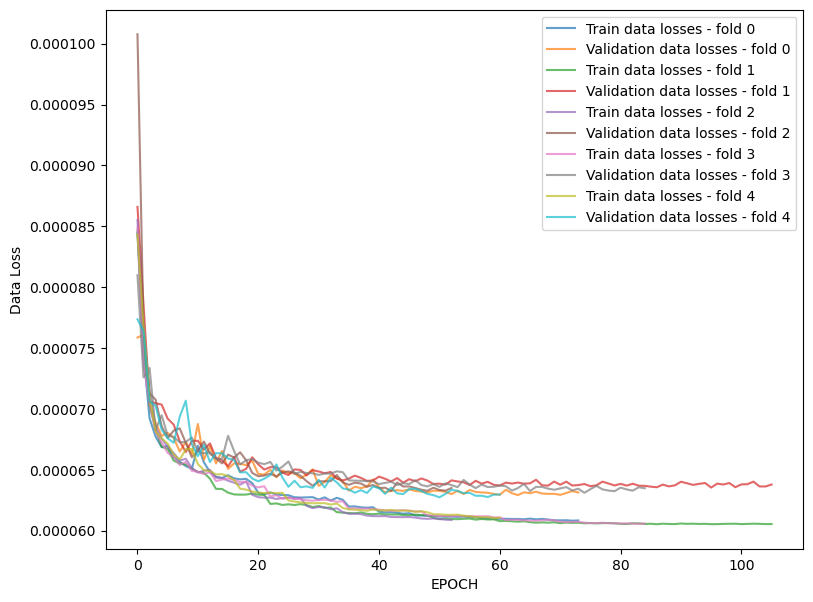

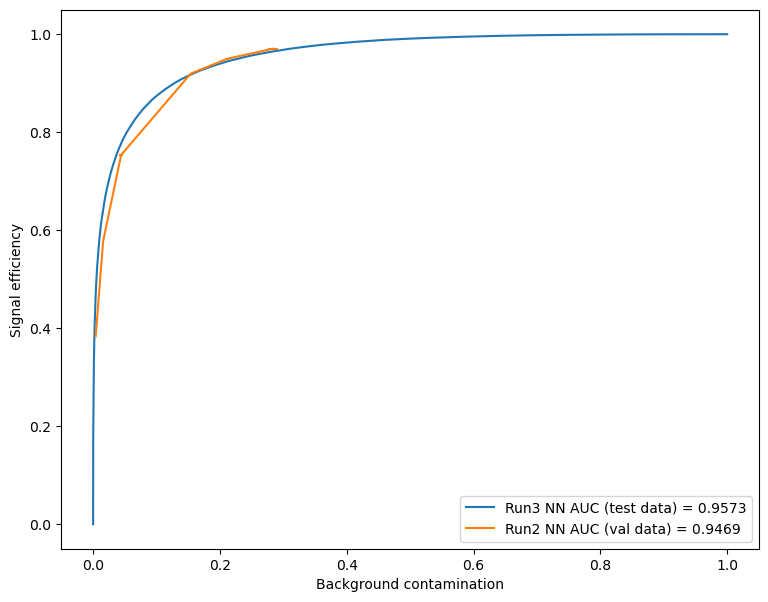

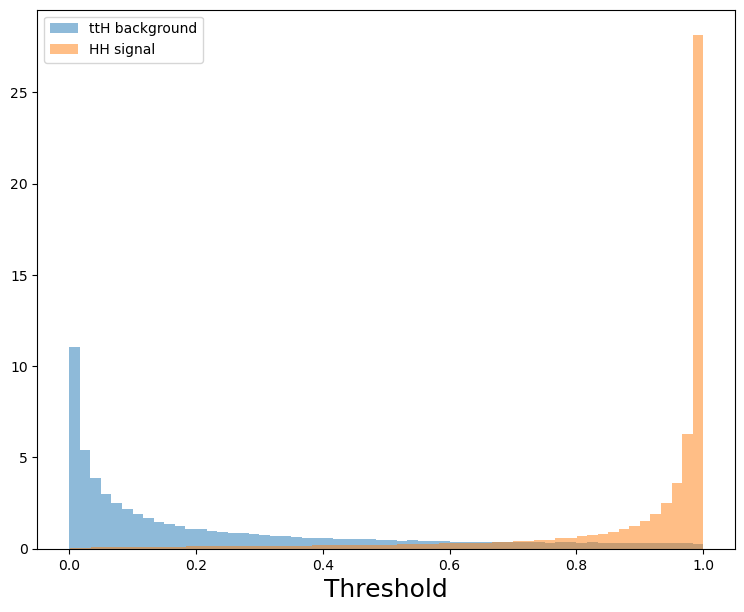

In [ ]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0])] = value  

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]

fprs = []
base_tpr = np.linspace(0, 1, 5000)
thresholds = []
# volatile=True
best_batch_size = bestconf['batch_size']
# for train_index, test_index in skf.split(data_hlf, label):
val_loader = DataLoader(
    ParticleHLF(data_list_test, data_hlf_test, label_test), 
    batch_size=bestconf['batch_size'],
    shuffle=False
)
all_pred = np.zeros(shape=(len(data_hlf_test),2))
all_label = np.zeros(shape=(len(data_hlf_test)))
criterion= nn.NLLLoss()

# CURRENT_TIME = '2024-08-08_17-12-14'
for fold_idx in range(skf.get_n_splits()):
    model.load_state_dict(torch.load(OUTPUT_DIRPATH + f'{CURRENT_TIME}_ReallyTopclassStyle_{fold_idx}.torch'))
    model.eval()
    with torch.no_grad():
        for batch_idx, (particles_data, hlf_data, y_data) in enumerate(val_loader):
            # print(f"val_loader: {batch_idx}")
            particles_data = particles_data.numpy()
            arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
            arr = [1 if x==0 else x for x in arr]
            arr = np.array(arr)
            sorted_indices_la= np.argsort(-arr)
            particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
            hlf_data = hlf_data[sorted_indices_la]
            particles_data = Variable(particles_data).cuda()
            hlf_data = Variable(hlf_data).cuda()
            # particles_data = Variable(particles_data)
            # hlf_data = Variable(hlf_data)
            t_seq_length= [arr[i] for i in sorted_indices_la]
            particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

            outputs = model(particles_data, hlf_data)

            # Unsort the predictions (to match the original data order)
            # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
            b = np.argsort(sorted_indices_la)
            unsorted_pred = outputs[b].data.cpu().numpy()

            fill_array(all_pred, unsorted_pred, batch_idx, best_batch_size)
            fill_array(all_label, y_data.numpy(), batch_idx, best_batch_size)

    fpr, tpr, threshold = roc_curve(all_label, np.exp(all_pred)[:,1])

    fpr = np.interp(base_tpr, tpr, fpr)
    threshold = np.interp(base_tpr, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr)

# [tl.tolist() for tl in train_losses_arr]


IN_perf = {
    'train_losses_arr': train_losses_arr,
    'val_losses_arr': val_losses_arr,
    'fprs': fprs.tolist(),
    'thresholds': thresholds.tolist(),
    'mean_fprs': mean_fprs.tolist(),
    'mean_thresholds': mean_thresholds.tolist(),
    'base_tpr': base_tpr.tolist(),
    'mean_area': float(mean_area),
    'all_pred': all_pred.tolist(),
    'all_label': all_label.tolist()
}

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_{fold_idx}.json', 'w') as f:
    json.dump(IN_perf, f)

# with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}IN_perf_{fold_idx}.json', 'r') as f:
#     IN_perf = json.load(f)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plt.figure(figsize=(9,7))
for fold_idx in range(skf.get_n_splits()):
    plt.plot(range(len(IN_perf['train_losses_arr'][fold_idx])), IN_perf['train_losses_arr'][fold_idx], label=f"Train data losses - fold {fold_idx}", alpha=0.7)
    plt.plot(range(len(IN_perf['train_losses_arr'][fold_idx])), IN_perf['val_losses_arr'][fold_idx], label=f"Validation data losses - fold {fold_idx}", alpha=0.7)
# plt.plot(range(len(train_losses_arr[0])), train_losses_arr[0], label="Train data losses")
# plt.plot(range(len(train_losses_arr[0])), val_losses_arr[0], label="Validation data losses")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('EPOCH')
plt.ylabel('Data Loss')

# plt.figure(figsize=(9,7))
# plt.plot(range(EPOCHS), val_losses, label="val losses vs. epoch")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
# plt.legend(loc='best')
# plt.xlabel('EPOCH')
# plt.ylabel('Validation data Loss')

run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
plt.figure(figsize=(9,7))
plt.plot(IN_perf['mean_fprs'], IN_perf['base_tpr'],label="Run3 NN AUC (test data) = %.4f" % mean_area)
plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[all_label==0,1], bins=60, label='ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==1,1], bins=60, label='HH signal', alpha=0.5, density=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

with h5py.File("ReallyInclusive_ROC.h5","w") as out:
    out['FPR'] = mean_fprs
    out['dFPR'] = std_fprs
    out['TPR'] = base_tpr
    out['Thresholds'] = mean_thresholds
    print("Saved ROC.")
